In [1]:
# To determine which version you're using:
!pip show tensorflow

# For the latest nightly build:
# !pip install tf-nightly
# For the current version: 
#!pip install --upgrade tensorflow

# For a specific version:
#!pip install tensorflow==1.2


Name: tensorflow
Version: 2.2.0rc3
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.6/dist-packages
Requires: grpcio, gast, opt-einsum, google-pasta, h5py, tensorboard, tensorflow-estimator, termcolor, wrapt, scipy, wheel, absl-py, astunparse, keras-preprocessing, six, protobuf, numpy
Required-by: fancyimpute


# Import


In [0]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import random
import math

import numpy as np
from PIL import Image
import os
import cv2

from skimage.util import random_noise

In [0]:
# Create an Image with the defined Height and Width
def createImage():
  ArrayZiel = []
  for y in range(0, IMG_Height):
    tempArray = []
    for x in range(0, IMG_Width):
      tempArray.append(0)
    ArrayZiel.append(np.array(tempArray))
  return np.array(ArrayZiel)


In [0]:
# Add Noise to given Image
def add_gaussian_noise(img):
    mean = 0
    var = 10
    sigma = var ** 0.5
    gaussian = np.random.normal(mean, sigma, (IMG_Height, IMG_Width))

    noisy_image = np.zeros(img.shape, np.float32)

    if len(img.shape) == 2:
        noisy_image = img + gaussian
    else:
        noisy_image[:, :, 0] = img[:, :, 0] + gaussian
        noisy_image[:, :, 1] = img[:, :, 1] + gaussian
        noisy_image[:, :, 2] = img[:, :, 2] + gaussian

    cv2.normalize(noisy_image, noisy_image, 0, 255, cv2.NORM_MINMAX, dtype=-1)
    noisy_image = noisy_image.astype(np.uint8)

    return noisy_image


In [0]:
# nimmt das Image und fügt eine MehrDimensionale Tabelle ein.
def addTabel_Mehrdimensional(image):
  x1 = int(random.randint(0, IMG_Width-22))
  x2 = int(random.randint(x1+20, IMG_Width-2))

  y1 = int(random.randint(1, IMG_Height/2))
  y2 = int(random.randint(y1+1, IMG_Height-2))

  Tabelle = np.zeros(image.shape, np.float32)

  width = x2-x1
  height = y2-y1

  AnzahlTabellen = random.randint(2,5)

  # Berechne Tabelle:
  b = int(width / AnzahlTabellen)

  for x in range(x1,x2):
    for y in range(y1, y2):
      Temp = math.sin(((x-x1) / b) * 2 * math.pi)
      if(Temp > 0):
        image[y][x] = 100
        Tabelle[y][x] = 1
      else:
        image[y][x] = 70
        Tabelle[y][x] = 1

  # Addieren beide Bilder zusammen
  image = np.stack((image, image, image), axis=2)
  Tabelle = np.stack((Tabelle, Tabelle, Tabelle), axis=2)

  # image = np.resize(image, (IMG_Height, IMG_Width, 3))
  # Tabelle = np.resize(Tabelle, (IMG_Height, IMG_Width, 3))

  return image, x1, y1, x2, y2, Tabelle


# nimmt das Image und fügt eine einDimensionale Tabelle ein.
def addTabel_EinDimensional(image):
  x1 = int(random.randint(0, IMG_Width-22))
  x2 = int(random.randint(x1+20, IMG_Width-2))

  width = x2-x1

  Tabelle = np.zeros(image.shape, np.float32)

  AnzahlTabellen = random.randint(2,5)

  # Berechne Tabelle:
  b = int(width / AnzahlTabellen)

  for x in range(x1,x2):
    y = 0
    Temp = math.sin(((x-x1) / b) * 2 * math.pi)
    if(Temp > 0):
      image[y][x] = 1
      Tabelle[y][x] = 1
    else:
      image[y][x] = 0
      Tabelle[y][x] = 0

  return image, x1, x2, Tabelle

In [0]:
def CreateLabelData_EinDimensional(x1, x2):
  Array = []

  Array.append(x1)
  Array.append(x2)
  return Array


def CreateLabelData_MehrDimensional(x1, y1, x2, y2):
  Array = []

  Array1 = []
  Array1.append(x1)
  Array1.append(y1)
  Array1 = np.asarray(Array1)
  Array.append(Array1)

  Array1 = []
  Array1.append(x2)
  Array1.append(y2)
  Array1 = np.asarray(Array1)
  Array.append(Array1)

  Array = np.asarray(Array)
  return Array

In [0]:
# Baue noch einen Callback ein, damit das Training (hoffentlich) weniger Zeit in anspruch nimmt
# Soll bei einer festgelegten Loss das Training unterbrechen

class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs = {}):
    if logs.get('loss') < LossZumAbbruchDesTrainings:
      print("\n Low loss so cancelling the training")
      self.model.stop_training = True

In [0]:
def TrainDataGenerator(AnzahlAnDaten):
  TrainDataset = []
  TrainLabelSet = []
  TrainTabelSet = []

  for i in range(0, AnzahlAnDaten):
    image = createImage()
    image = add_gaussian_noise(image)
    image, x1,y1,x2,y2,tabel = addTabel_Mehrdimensional(image)
    TrainTabelSet.append(tabel)
    labelArray = CreateLabelData_EinDimensional(x1, x2)
    TrainDataset.append(np.asarray(image))
    TrainLabelSet.append(np.asarray(labelArray))

  TrainDataset = np.asarray(TrainDataset, dtype=np.float32)
  TrainLabelSet = np.asarray(TrainLabelSet, dtype=np.float32)
  TrainTabelSet = np.asarray(TrainTabelSet, dtype=np.float32)

  return TrainDataset, TrainLabelSet, TrainTabelSet

def TestDataGenerator(AnzahlAnDaten):
  TestDataSet = []
  TestLabelSet = []
  TestTabelSet = []

  for i in range(0, AnzahlAnDaten):
    # Erstellen der TestDaten
    image = createImage()
    image = add_gaussian_noise(image)
    image, x1,y1,x2,y2,tabel = addTabel_Mehrdimensional(image)
    labelArray = CreateLabelData_EinDimensional(x1, x2)
    TestTabelSet.append(tabel)
    TestDataSet.append(np.asarray(image))
    TestLabelSet.append(np.asarray(labelArray))

  TestDataSet = np.asarray(TestDataSet, dtype=np.float32)
  TestTabelSet = np.asarray(TestTabelSet, dtype=np.float32)
  TestLabelSet = np.asarray(TestLabelSet, dtype=np.float32)

  return TestDataSet, TestTabelSet, TestLabelSet

# Erster Test: Ein Dimensional


In [0]:
# Variablen

%load_ext tensorboard

IMG_Height = 32
IMG_Width = 64

AnzahlAnTrainDaten = 10000
AnzahlAnTestDaten = 1000
DropoutRate = 0.5

LossZumAbbruchDesTrainings = 0.7

## 1) Daten Erzeugen

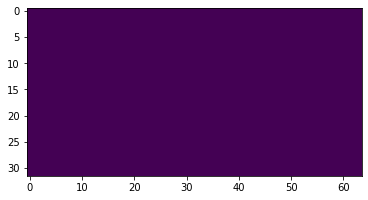

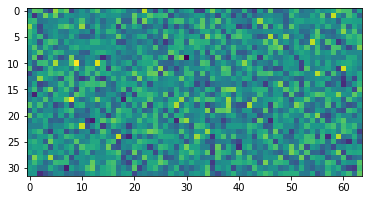

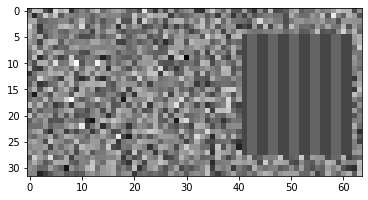

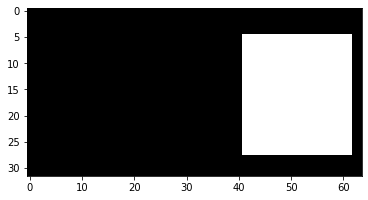

41-----62


In [9]:
# Bild Erzeuger
image = createImage()

plt.imshow(image)
plt.show()

image = add_gaussian_noise(image)

plt.imshow(image)
plt.show()

# add Table
image, x1,y1,x2,y2,tabel = addTabel_Mehrdimensional(image)

plt.imshow(image)
plt.show()

plt.imshow(tabel)
plt.show()

print(str(x1) + '-----' + str(x2))

In [10]:
TrainDataset, TrainLabelSet, TrainTabelSet = TrainDataGenerator(AnzahlAnTrainDaten)
print(TrainDataset.shape)
print(TrainTabelSet.shape)

(10000, 32, 64, 3)
(10000, 32, 64, 3)


# Mehrere Modelle und Ideen

##Model 1 -> unverändert

In [12]:
input = keras.layers.Input((IMG_Height, IMG_Width, 3))

model = tf.keras.applications.MobileNetV2()(input)
CNN = keras.layers.Dense(IMG_Height*IMG_Width*4, activation='sigmoid')(model)

for i in range(2,5):
  CNN = tf.keras.layers.concatenate((CNN, model))
  CNN = keras.layers.Dense(IMG_Height*IMG_Width*2, activation='sigmoid')(CNN)

Zusammen = tf.keras.layers.concatenate((CNN, model))

DNN = keras.layers.Dense(IMG_Height*IMG_Width*4, activation='softmax')(Zusammen)

Output = keras.layers.Dense(IMG_Height*IMG_Width*3)(DNN)
Output = keras.layers.Reshape(TrainTabelSet[0].shape)(Output)

model = keras.models.Model(input, Output)

In [0]:
opt = keras.optimizers.Adam(learning_rate=0.5)

model.compile(loss='categorical_crossentropy',
            optimizer='adam',
            metrics=['accuracy'])



### Training

In [0]:
callbacks = myCallback()

# history = model.fit(x = TrainDataset, y = TrainTabelSet, shuffle=True, epochs=10, validation_split=0.3, callbacks=[keras.callbacks.TerminateOnNaN()])     

In [15]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.plot(history.history['loss'], label = 'loss')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='center right')
plt.show()

TestDataSet, TestTabelSet, TestLabelSet = TestDataGenerator(AnzahlAnTestDaten)

test_loss, test_acc = model.evaluate(TestDataSet, TestTabelSet, verbose=2)
print(test_acc)

NameError: ignored

###Auswertung

In [0]:
image, TrainLabelSet, tabel = TrainDataGenerator(1)

print(image[0].shape)

prediction = model.predict(image)

plt.imshow(tabel[0])
plt.show()

plt.imshow(prediction[0])
plt.show()


In [0]:
# tf.keras.utils.plot_model(model, show_shapes=True)

In [0]:
# model.summary()

# Model 2 -> weniger Schichten

In [0]:
input = keras.layers.Input((IMG_Height, IMG_Width, 3))

model = tf.keras.applications.MobileNetV2()(input)
CNN = keras.layers.Dense(IMG_Height*IMG_Width*4, activation='sigmoid')(model)

for i in range(2,4):
  CNN = tf.keras.layers.concatenate((CNN, model))
  CNN = keras.layers.Dense(IMG_Height*IMG_Width*2, activation='sigmoid')(CNN)

Zusammen = tf.keras.layers.concatenate((CNN, model))

Output = keras.layers.Dense(IMG_Height*IMG_Width*3)(Zusammen)
Output = keras.layers.Reshape(TrainTabelSet[0].shape)(Output)

model = keras.models.Model(input, Output)

In [0]:
opt = keras.optimizers.Adam(learning_rate=0.5)

model.compile(loss='categorical_crossentropy',
            optimizer='adam',
            metrics=['accuracy'])

In [0]:
# history = model.fit(x = TrainDataset, y = TrainTabelSet, shuffle=True, epochs=10, validation_split=0.3, callbacks=[keras.callbacks.TerminateOnNaN()])     

In [0]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.plot(history.history['loss'], label = 'loss')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='center right')
plt.show()

TestDataSet, TestTabelSet, TestLabelSet = TestDataGenerator(AnzahlAnTestDaten)

test_loss, test_acc = model.evaluate(TestDataSet, TestTabelSet, verbose=2)
print(test_acc)

In [0]:
image, TrainLabelSet, tabel = TrainDataGenerator(1)

print(image[0].shape)

prediction = model.predict(image)

plt.imshow(tabel[0])
plt.show()

plt.imshow(prediction[0])
plt.show()

# Model 3 -> kleinere learning Rate

In [0]:
input = keras.layers.Input((IMG_Height, IMG_Width, 3))

model = tf.keras.applications.MobileNetV2()(input)
CNN = keras.layers.Dense(IMG_Height*IMG_Width*4, activation='sigmoid')(model)

for i in range(2,5):
  CNN = tf.keras.layers.concatenate((CNN, model))
  CNN = keras.layers.Dense(IMG_Height*IMG_Width*2, activation='sigmoid')(CNN)

Zusammen = tf.keras.layers.concatenate((CNN, model))

DNN = keras.layers.Dense(IMG_Height*IMG_Width*4, activation='softmax')(Zusammen)

Output = keras.layers.Dense(IMG_Height*IMG_Width*3)(DNN)
Output = keras.layers.Reshape(TrainTabelSet[0].shape)(Output)

model = keras.models.Model(input, Output)

In [0]:
opt = keras.optimizers.Adam(learning_rate=0.25)

model.compile(loss='categorical_crossentropy',
            optimizer=opt,
            metrics=['accuracy'])

In [0]:
# history = model.fit(x = TrainDataset, y = TrainTabelSet, shuffle=True, epochs=20, validation_split=0.3, callbacks=[keras.callbacks.TerminateOnNaN()] )  

In [16]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.plot(history.history['loss'], label = 'loss')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.3, 1])
plt.legend(loc='center right')
plt.show()

TestDataSet, TestTabelSet, TestLabelSet = TestDataGenerator(AnzahlAnTestDaten)

test_loss, test_acc = model.evaluate(TestDataSet, TestTabelSet, verbose=2)
print(test_acc)

NameError: ignored

In [0]:
image, TrainLabelSet, tabel = TrainDataGenerator(1)

print(image[0].shape)

prediction = model.predict(image)

plt.imshow(tabel[0])
plt.show()

plt.imshow(prediction[0])
plt.show()

# Model 4 -> Kleineres Modell, kleinere Lernratte

In [16]:
input = keras.layers.Input((IMG_Height, IMG_Width, 3))

model = tf.keras.applications.MobileNetV2()(input)
CNN = keras.layers.Dense(IMG_Height*IMG_Width*4, activation='sigmoid')(model)

for i in range(2,4):
  CNN = tf.keras.layers.concatenate((CNN, model))
  CNN = keras.layers.Dense(IMG_Height*IMG_Width*2, activation='sigmoid')(CNN)

Zusammen = tf.keras.layers.concatenate((CNN, model))

Output = keras.layers.Dense(IMG_Height*IMG_Width*3)(Zusammen)
Output = keras.layers.Reshape(TrainTabelSet[0].shape)(Output)

model = keras.models.Model(input, Output)

In [0]:
opt = keras.optimizers.Adam(learning_rate=0.25)

model.compile(loss='categorical_crossentropy',
            optimizer=opt,
            metrics=['accuracy'])

In [18]:
history = model.fit(x = TrainDataset, y = TrainTabelSet, shuffle=True, epochs=30, validation_split=0.3, callbacks=[keras.callbacks.TerminateOnNaN()])  

Epoch 1/30
219/219 [==============================] - 203s 929ms/step - loss: 2.6301 - accuracy: 0.3289 - val_loss: 2.6885 - val_accuracy: 0.3291
Epoch 2/30
219/219 [==============================] - 207s 947ms/step - loss: 2.6289 - accuracy: 0.3295 - val_loss: 2.6884 - val_accuracy: 0.3286
Epoch 3/30
219/219 [==============================] - 204s 933ms/step - loss: 2.6287 - accuracy: 0.3287 - val_loss: 2.6884 - val_accuracy: 0.3286
Epoch 4/30
219/219 [==============================] - 202s 921ms/step - loss: 2.6299 - accuracy: 0.3283 - val_loss: 2.6884 - val_accuracy: 0.3296
Epoch 5/30
219/219 [==============================] - 201s 917ms/step - loss: 2.6287 - accuracy: 0.3282 - val_loss: 2.6884 - val_accuracy: 0.3271
Epoch 6/30
219/219 [==============================] - 201s 918ms/step - loss: 2.6296 - accuracy: 0.3276 - val_loss: 2.6884 - val_accuracy: 0.3281
Epoch 7/30
219/219 [==============================] - 201s 918ms/step - loss: 2.6293 - accuracy: 0.3280 - val_loss: 2.6884 -

KeyboardInterrupt: ignored

In [0]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.plot(history.history['loss'], label = 'loss')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='center right')
plt.show()

TestDataSet, TestTabelSet, TestLabelSet = TestDataGenerator(AnzahlAnTestDaten)

test_loss, test_acc = model.evaluate(TestDataSet, TestTabelSet, verbose=2)
print(test_acc)

In [0]:
image, TrainLabelSet, tabel = TrainDataGenerator(1)

print(image[0].shape)

prediction = model.predict(image)

plt.imshow(tabel[0])
plt.show()

plt.imshow(prediction[0])
plt.show()

# Test - Nur mit einem Bild rechnen

In [19]:
input = keras.layers.Input((IMG_Height, IMG_Width, 3))

model = tf.keras.applications.MobileNetV2()(input)
CNN = keras.layers.Dense(IMG_Height*IMG_Width*4, activation='sigmoid')(model)

for i in range(2,5):
  CNN = tf.keras.layers.concatenate((CNN, model))
  CNN = keras.layers.Dense(IMG_Height*IMG_Width*2, activation='sigmoid')(CNN)

Zusammen = tf.keras.layers.concatenate((CNN, model))

DNN = keras.layers.Dense(IMG_Height*IMG_Width*4, activation='softmax')(Zusammen)

Output = keras.layers.Dense(IMG_Height*IMG_Width*3)(DNN)
Output = keras.layers.Reshape(TrainTabelSet[0].shape)(Output)

model = keras.models.Model(input, Output)

In [0]:
model.compile(loss='categorical_crossentropy',
            optimizer='adam',
            metrics=['accuracy'])

In [0]:
IMG_Height = 32
IMG_Width = 64

AnzahlAnTrainDaten = 1
AnzahlAnTestDaten = 1
DropoutRate = 0.5

LossZumAbbruchDesTrainings = 0.7

In [22]:
TrainDataset, TrainLabelSet, TrainTabelSet = TrainDataGenerator(AnzahlAnTrainDaten)
print(TrainDataset.shape)
print(TrainTabelSet.shape)

(1, 32, 64, 3)
(1, 32, 64, 3)


In [24]:
acc = []
loss = []

for i in range(0, 1000):
  history = model.fit(x = TrainDataset, y = TrainTabelSet, shuffle=True, callbacks=[keras.callbacks.TerminateOnNaN()])
  acc.append(history.history['accuracy'][0])
  loss.append(history.history['loss'][0])

1/1 [==============================] - 0s 1ms/step - loss: 9.0225 - accuracy: 0.3560


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Unrecognized location 'center down'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  


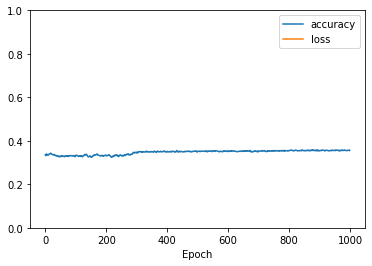

In [25]:
plt.plot(acc, label='accuracy')
plt.plot(loss, label = 'loss')

plt.xlabel('Epoch')
plt.ylim([0, 1])
plt.legend(loc='upper right')
plt.show()